In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm
from glob import glob
from scipy.stats import norm
from scipy.special import softmax
from datetime import datetime, time

from model import baseline
from model.helpers import square_exponential_kernel, normalize_last_dim
from plot import plot
from data.data_path import data_path
from scripts.compute_transition_matrices import plot_transition_matrix

In [3]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [4]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

n_timestep = 20
n_velocity = 20

jitter = np.finfo(np.float64).tiny

In [5]:
# ------------------------------------------------------------------------
# Compute cumulative step number and its derivative
# ------------------------------------------------------------------------

# Load data
step_events = load_data(user)

n_days = len(step_events)

timestep = np.linspace(0, 1, n_timestep)
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps[idx_day] = np.gradient(cum_steps_day, timestep) / timestep.size
    
sum_steps = np.sum(deriv_cum_steps, axis=1)
print(f"{np.max(sum_steps):.02f} +/= {np.std(sum_steps):.02f}")


7291.25 +/= 2496.51


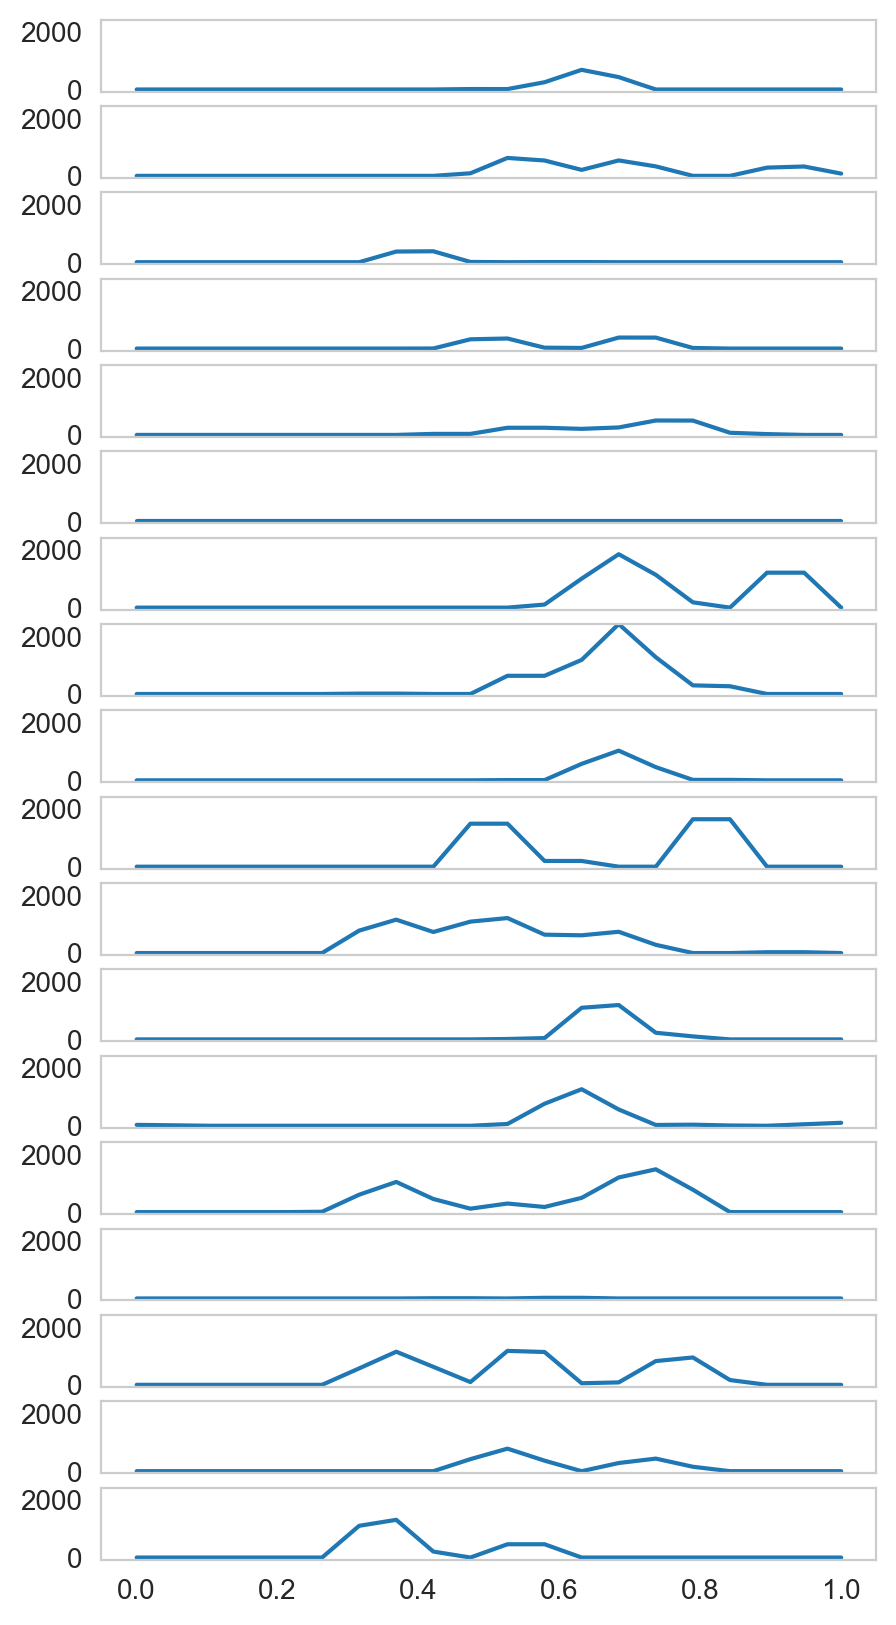

In [6]:
fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(5, 10))
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [7]:
mu = 500*np.cos(3 * (timestep - 2))
sigma = square_exponential_kernel(timestep, 50,  0.5)
push_effect = np.random.multivariate_normal(mu, sigma, size=300)

Text(0, 0.5, 'push effect (hashtag steps)')

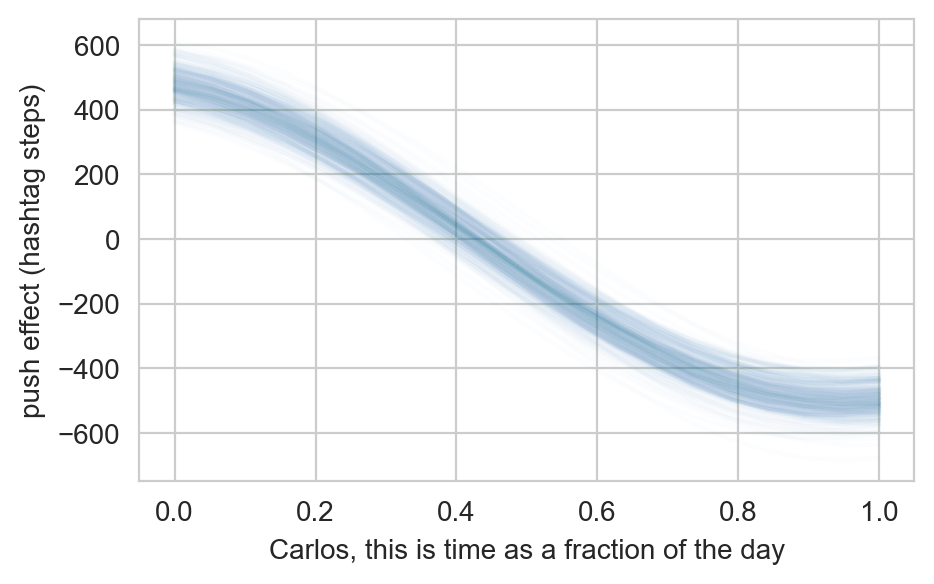

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(timestep, push_effect.T, color="C0", alpha=0.01);
ax.set_xlabel("Carlos, this is time as a fraction of the day")
ax.set_ylabel("push effect (" + r"hashtag" +" steps)")

In [9]:
activity = np.zeros((2, ) + tuple(deriv_cum_steps.shape))
activity[0] = deriv_cum_steps
activity[1] = deriv_cum_steps + push_effect[:deriv_cum_steps.shape[0]]

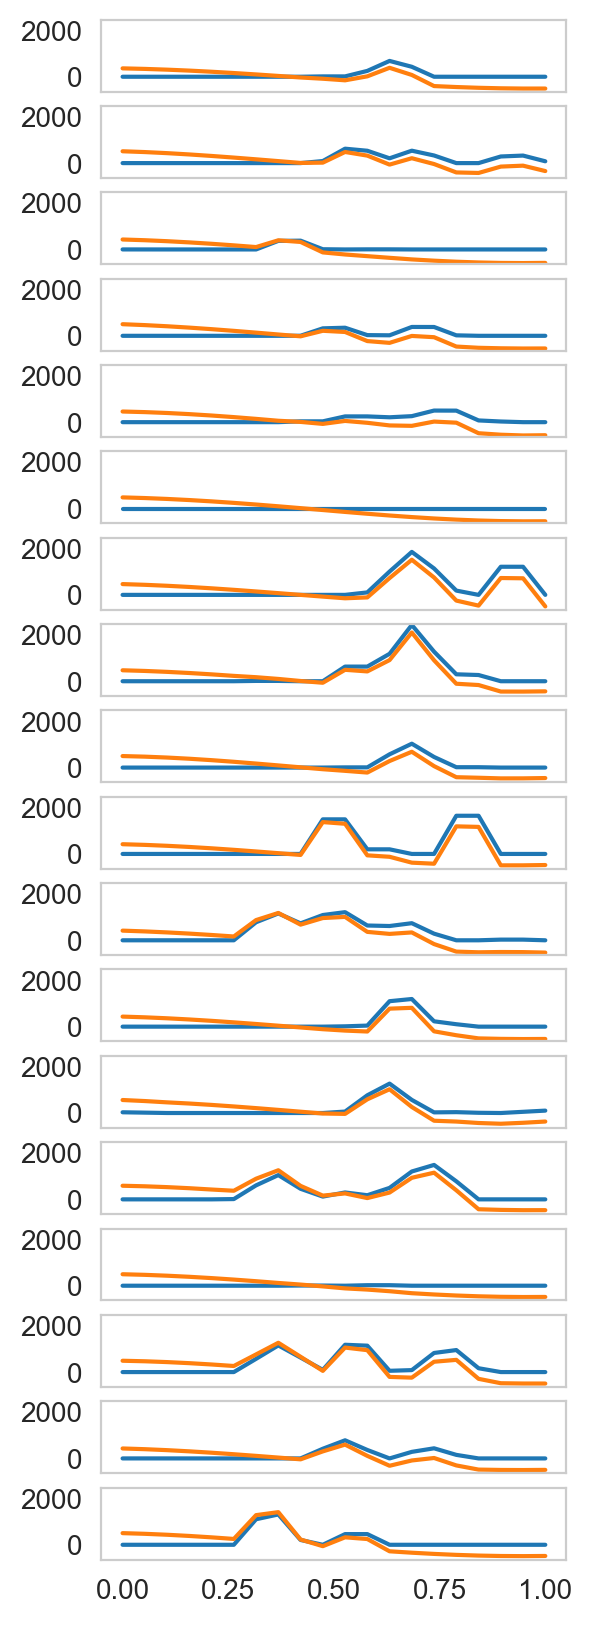

In [10]:
n_samples = deriv_cum_steps.shape[0]  # Number of days
fig, axes = plt.subplots(n_samples, figsize=(3, 10), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(timestep, activity[0, i], color="C0")
    ax.plot(timestep, activity[1, i], color="C1")
    ax.set_ylim(np.min(activity) - 50, np.max(activity) + 40)
    ax.grid(False)

In [11]:
# Transform
n_action = 2
# velocity = np.concatenate((np.zeros(1), np.logspace(-4, 4, n_velocity - 1)))
velocity = np.linspace(0, np.max(activity)+50, 5)#np.concatenate((np.zeros(1), np.geomspace(30, np.max(activity), 19)))

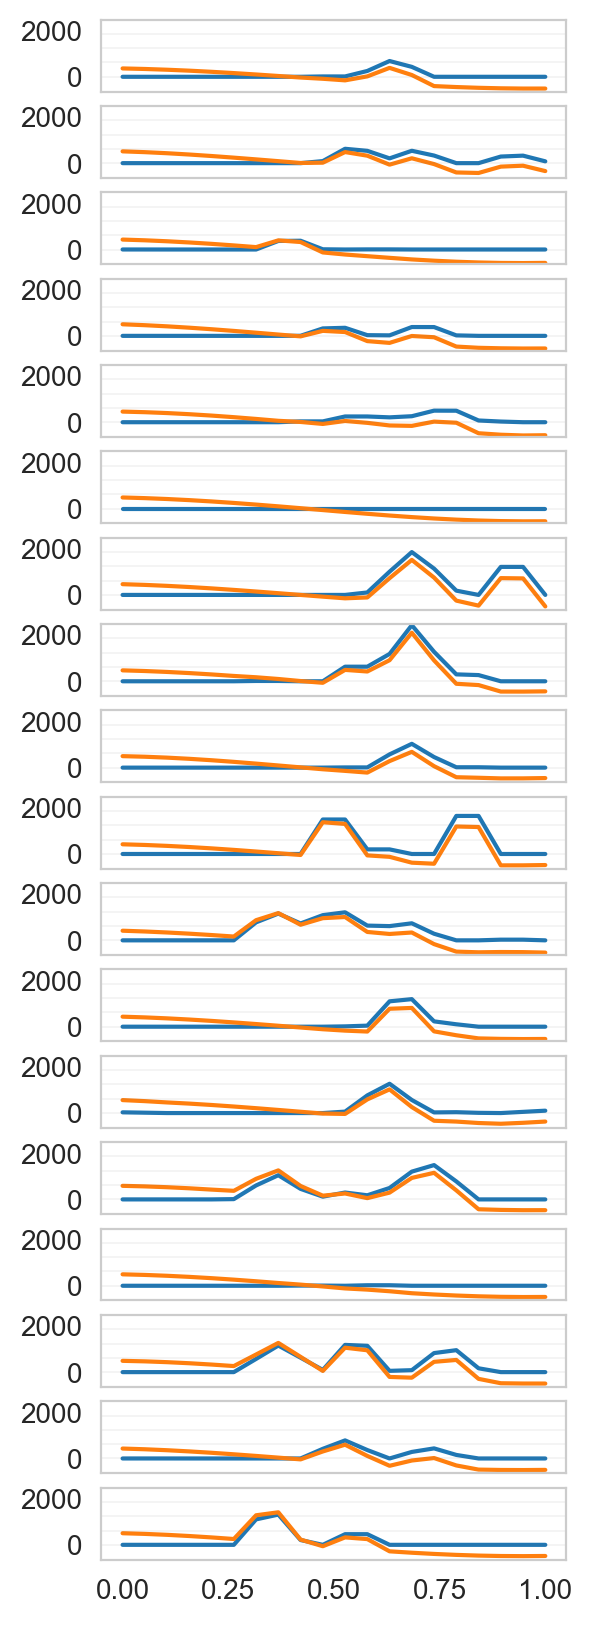

In [12]:
n_samples = deriv_cum_steps.shape[0]  # Number of days
fig, axes = plt.subplots(n_samples, figsize=(3, 10), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(timestep, activity[0, i], color="C0")
    ax.plot(timestep, activity[1, i], color="C1")
    ax.set_ylim(-50 + np.min(activity), np.max(activity)+50)
    ax.grid(False)
    for v in velocity:
        ax.axhline(y=v, color="0.4", linewidth=0.05)

In [13]:
# Add some jitter
jitter = 0.0001
alpha_atvv = np.zeros((n_action, timestep.size-1, velocity.size, velocity.size)) + jitter

# Add one bin for infinity
bins = np.concatenate((velocity, np.full(1, np.inf)))

for idx_day in range(n_days):
    for action in range(n_action):
        drv = np.clip(activity[action, idx_day], bins[0], bins[-1])
        v_idx = np.digitize(drv, bins, right=False) - 1
        for t in range(v_idx.size - 1):
            alpha_atvv[action, t, v_idx[t], v_idx[t + 1]] += 1


In [42]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

X_train = []
X_to_predict = []
y_train = []

jitter_sum = jitter*alpha_atvv.shape[-1] # Sum of all jitter values

for action in range(n_action):
    for t in range(timestep.size - 1):
        for v_past in range(velocity.size):
            sum_last_dim = alpha_atvv[action, t, v_past, :].sum()
            if sum_last_dim > jitter_sum*2:
                for v_future in range(velocity.size):
                    X_train.append([
                        action, 
                        timestep[t], 
                        velocity[v_past], 
                        velocity[v_future]
                    ])
                    y_train.append(
                        np.log(alpha_atvv[action, t, v_past, v_future]))
            else:
                for v_future in range(velocity.size):
                    X_to_predict.append([
                        action, 
                        timestep[t], 
                        velocity[v_past], 
                        velocity[v_future]
                    ])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_to_predict = np.asarray(X_to_predict)
# print(f"X_train {X_train.shape} y_train {y_train.shape}")

In [43]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

7.12**2 * RBF(length_scale=0.0472)

In [44]:
mean_prediction, std_prediction = gaussian_process.predict(X_to_predict, return_std=True)

In [48]:
re_alpha_atvv = np.zeros_like(alpha_atvv)
marker = np.zeros_like(alpha_atvv)

pred_idx = 0
for action in range(n_action):
    for t in range(timestep.size - 1):
        for v_past in range(velocity.size):
            sum_last_dim = alpha_atvv[action, t, v_past, :].sum()
            if sum_last_dim > jitter_sum:
                re_alpha_atvv[action, t, v_past, :] = alpha_atvv[action, t, v_past, :].copy()
                marker[action, t, v_past, :] = alpha_atvv[action, t, v_past, :].copy()
            else:
                for v_future in range(velocity.size):
                    re_alpha_atvv[action, t, v_past, v_future] = np.exp(mean_prediction[pred_idx])
                    marker[action, t, v_past, v_future] = np.inf
                    pred_idx += 1

In [49]:
# Compute expected probabilities
transition_velocity_atvv = normalize_last_dim(re_alpha_atvv) # Expected value given Dirichlet distribution parameterised by alpha

# Make sure that all probabilities sum to (more or less) one
np.allclose(np.sum(transition_velocity_atvv, axis=-1), 1) 

True

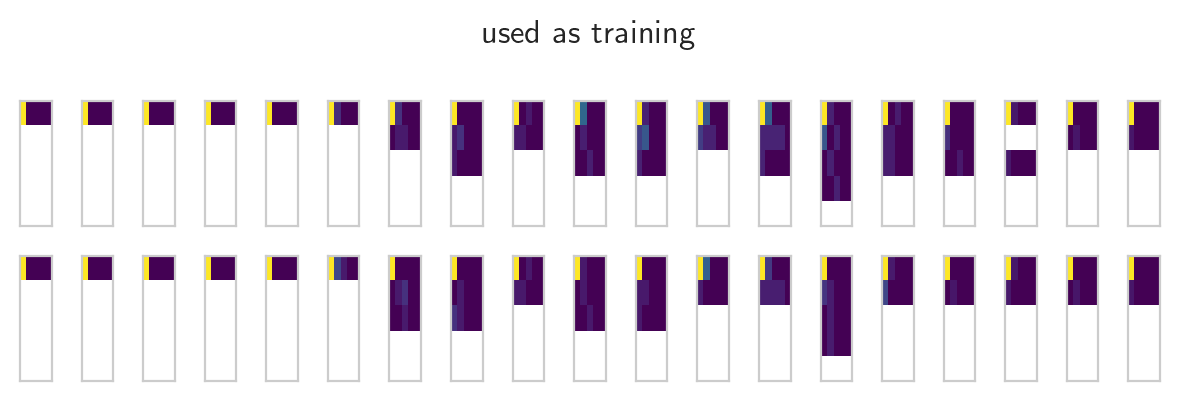

In [51]:
plot.q(marker, title="used as training")

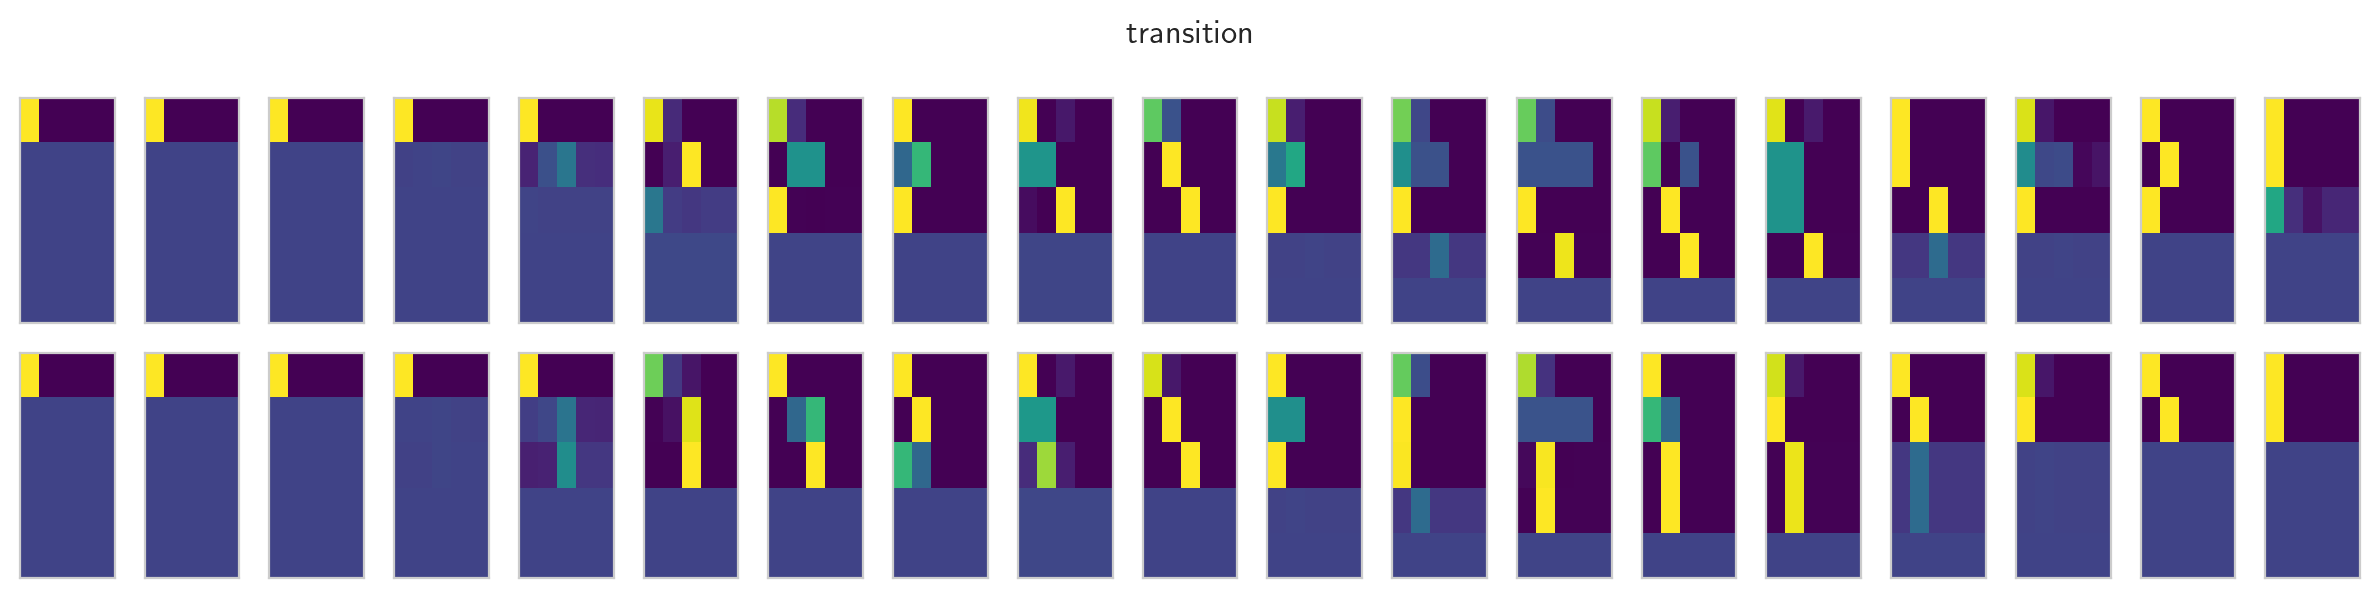

In [47]:
# Plot
plot.q(transition_velocity_atvv, 
       title="transition", 
       figsize=(12, 3), 
       cmap="viridis")

In [35]:
position = np.linspace(0, np.max(sum_steps)*1.2, 20)
# Compute position transition matrix
sigma_transition_position = 20
tr = np.zeros((position.size, velocity.size, position.size))
for p_idx, p in enumerate(position):
    for v_idx, v in enumerate(velocity):
        dist = norm.pdf(position, loc=p + v, scale=sigma_transition_position)
        if np.sum(dist) == 0:
            dist[-1] = 1 # All weight on greatest position  
        tr[p_idx, v_idx, :] = dist
        
transition_position_pvp = normalize_last_dim(tr)

# Make sure that all probabilities sum to (more or less) one
np.allclose(np.sum(transition_position_pvp, axis=-1), 1) 

True

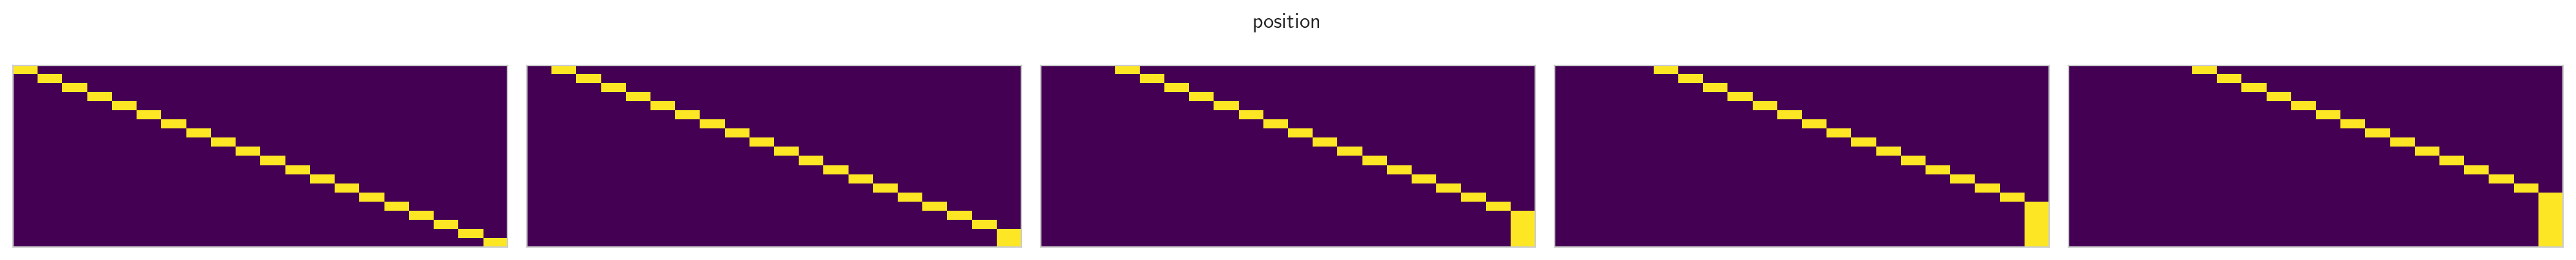

In [36]:
plot.q(transition_position_pvp, "position", (20, 2))

In [37]:
n_position = position.size
n_velocity = velocity.size
n_timestep = timestep.size
compute_q = normalize_last_dim

log_prior = np.log(softmax(np.arange(n_position)))

# Pragmatic values: demonstrate that it works for one timestep

In [38]:
v_idx = 1
pos_idx = 0
t_idx = 5

qv = np.zeros(n_velocity)
qv[v_idx] = 1.
qp = np.zeros(n_position)
qp[pos_idx] = 1.

qvs = np.zeros((n_action, n_velocity))
qps = np.zeros((n_action, n_position))
for action_idx, a in enumerate(range(n_action)):
    
    print(action_idx)

    qv_new = qv @ transition_velocity_atvv[a, t_idx, :, :]
    qp_new = qp @ (qv_new @ transition_position_pvp)
    qvs[action_idx] = qv_new
    qps[action_idx] = qp_new

pragmatic = np.sum(qps * log_prior, axis=1)
print("pragmatic values", pragmatic)

e_v = np.zeros(2)
for a in range(2):
    e_v[a] = np.average(velocity, weights=transition_velocity_atvv[a, t_idx, v_idx, :])
print("expected velocities", e_v)

0
1
pragmatic values [-16.6112736  -16.56695402]
expected velocities [1189.67798814 1200.71636973]


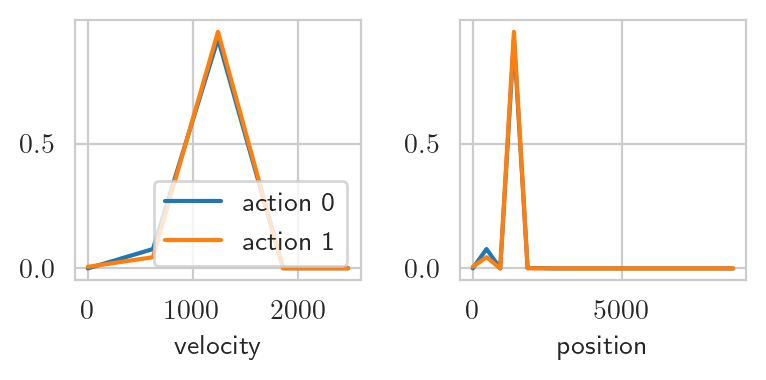

In [39]:
fig, axes = plt.subplots(figsize=(4, 2), ncols=2)

ax = axes[0]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(velocity, qvs[action_idx], label=f"action {a}")

ax.set_xlabel("velocity")
ax.legend(loc="lower right")

ax = axes[1]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(position, qps[action_idx], label=f"action {a}")

ax.set_xlabel("position")
plt.tight_layout()

# Pragmatic values: demonstrate that it works for a run

In [40]:
horizon = 1
n_sample_run = 100

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep-1)), np.zeros((n_sample_run, n_timestep-1))

# For each sample...
for sample in range(n_sample_run):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(1234 + sample*123)

    for t_idx in range(n_timestep-1):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                rollout_t_index = t_idx + h_idx
                qv = qv @ transition_velocity_atvv[a, rollout_t_index, :, :]
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ log_prior)

        a = np.random.choice(
            np.arange(len(action_plan))
            [pragmatic == pragmatic.max()])

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_atvv[a, t_idx, v_idx, :])
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

run = {
    "policy": "af-pragmatic", 
    "position": hist_pos, 
    "velocity": hist_vel
}

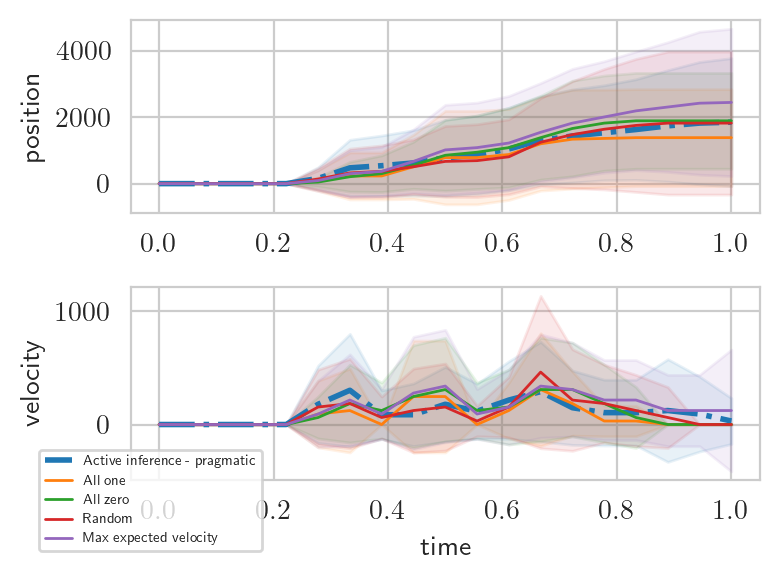

In [41]:
baselines = baseline.run(transition_velocity_atvv=transition_velocity_atvv, 
                         transition_position_pvp=transition_position_pvp, timestep=timestep, position=position, velocity=velocity)
plot.runs(run, *baselines)

# Epistemic value

### Learning the model (= inferring the transition) using a RANDOM policy

In [36]:
all_hist_err = {}
policies_err = []

In [37]:
n_episode = 1000
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*(n_timestep-1)))
hist_mean_ent = np.zeros_like(hist_err)

for sample in range(n_sample_run):

    _alpha_atvv = np.random.random((n_action, n_timestep-1, n_velocity, n_velocity)) + 0.001 #np.finfo(np.float64).eps

    if sample == 0:
        error = np.mean(np.absolute(transition_velocity_atvv - compute_q(_alpha_atvv)))
        print(f"Initial error {error:.4f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx in range(timestep.size-1):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            new_v_index = np.random.choice(
                np.arange(n_velocity), 
                p=transition_velocity_atvv[a, t_idx, v_idx, :])

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            _alpha_atvv[a, t_idx, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.mean(np.absolute(transition_velocity_atvv - compute_q(_alpha_atvv)))
            hist_err[sample, epoch] = error
            mean_ent = np.mean(np.sum(-_alpha_atvv * np.log(_alpha_atvv + 1e-16), axis=-1))
            hist_mean_ent[sample, epoch] = mean_ent
            
            # Increment epoch counter
            epoch += 1

    print(f"[Sample {sample+1:02d}/{n_sample_run}] Error after {epoch} epochs {error:.4f}")

run_random = {"policy": "random", "error": hist_err, "mean_ent": hist_mean_ent}

Initial error 0.1713
[Sample 01/20] Error after 19000 epochs 0.0594
[Sample 02/20] Error after 19000 epochs 0.0636
[Sample 03/20] Error after 19000 epochs 0.0605
[Sample 04/20] Error after 19000 epochs 0.0649
[Sample 05/20] Error after 19000 epochs 0.0667
[Sample 06/20] Error after 19000 epochs 0.0650
[Sample 07/20] Error after 19000 epochs 0.0627
[Sample 08/20] Error after 19000 epochs 0.0640
[Sample 09/20] Error after 19000 epochs 0.0654
[Sample 10/20] Error after 19000 epochs 0.0614
[Sample 11/20] Error after 19000 epochs 0.0606
[Sample 12/20] Error after 19000 epochs 0.0612
[Sample 13/20] Error after 19000 epochs 0.0602
[Sample 14/20] Error after 19000 epochs 0.0640
[Sample 15/20] Error after 19000 epochs 0.0621
[Sample 16/20] Error after 19000 epochs 0.0633
[Sample 17/20] Error after 19000 epochs 0.0664
[Sample 18/20] Error after 19000 epochs 0.0658
[Sample 19/20] Error after 19000 epochs 0.0617
[Sample 20/20] Error after 19000 epochs 0.0644


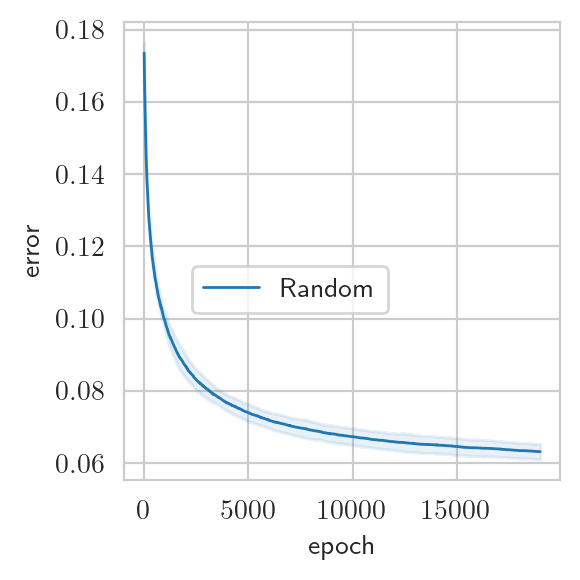

In [38]:
plot.error(run_random)

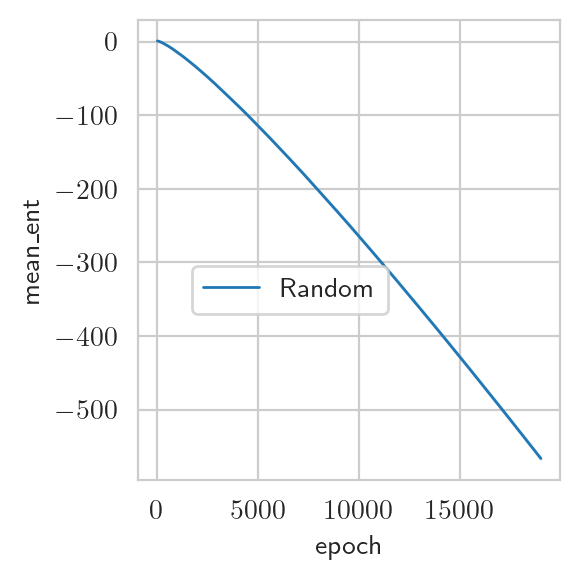

In [39]:
plot.error_like("mean_ent", run_random)

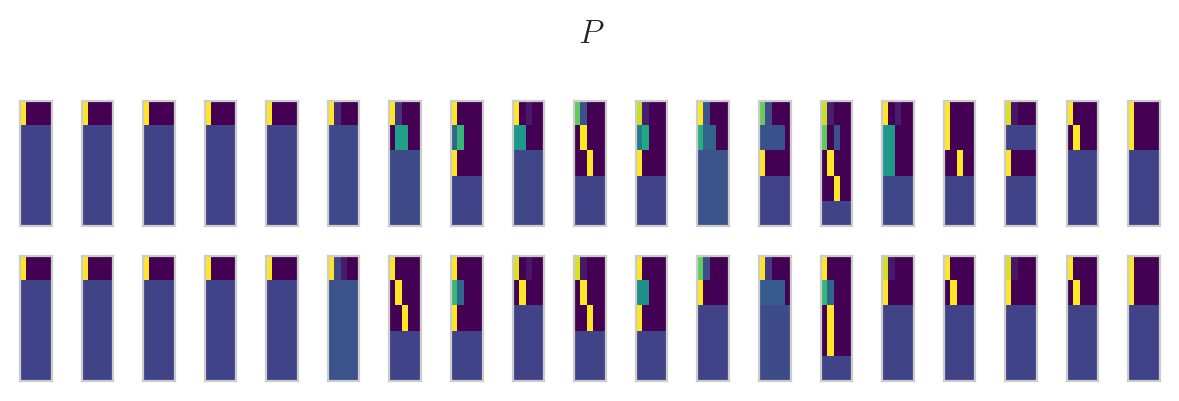

In [43]:
plot.q(transition_velocity_atvv, title="$P$")

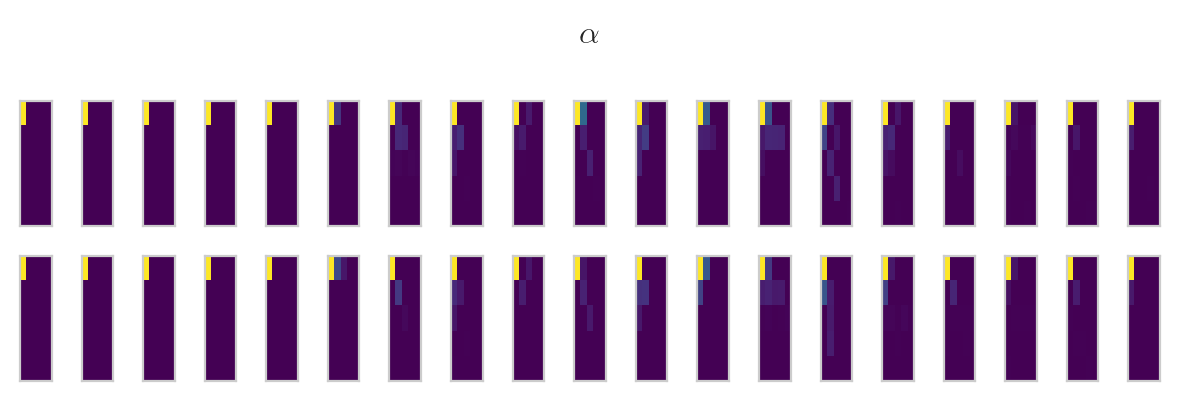

In [40]:
plot.q(_alpha_atvv, title=r"$\alpha$")

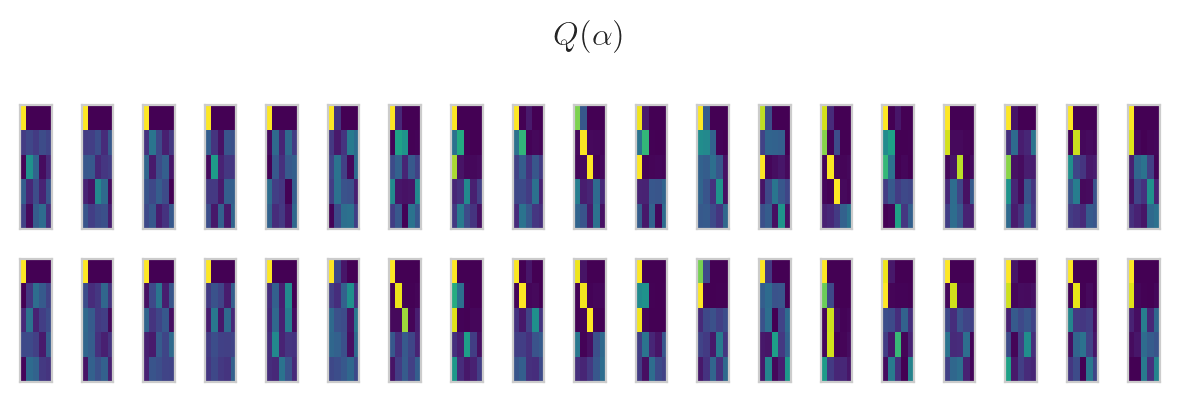

In [41]:
q = compute_q(_alpha_atvv)
plot.q(q, title=r"$Q(\alpha)$")

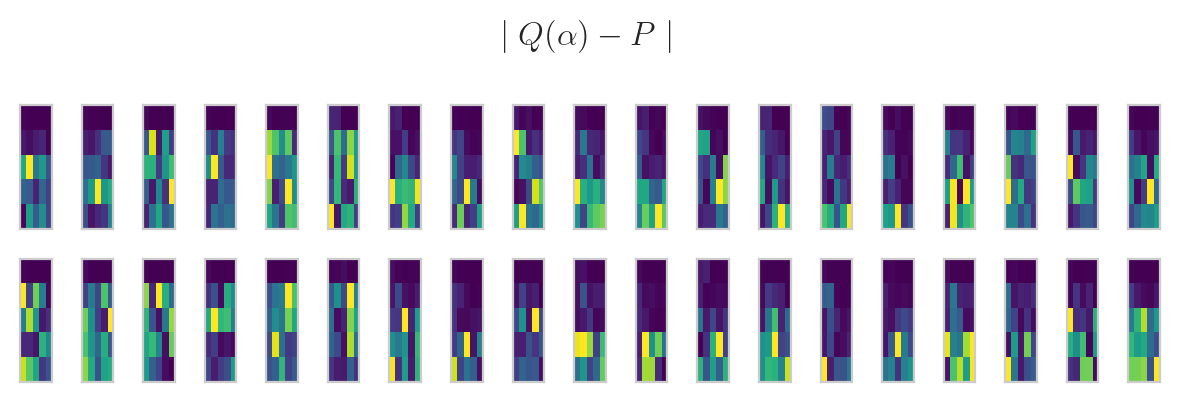

In [42]:
q = compute_q(_alpha_atvv)
diff = np.absolute(transition_velocity_atvv - q)
plot.q(diff, title=r"$\mid Q(\alpha) - P \mid$")

In [44]:
n_episode = 1000
n_sample_run = 20
horizon = 1  # len(timestep)
hist_err = np.zeros((n_sample_run, n_episode*(n_timestep-1)))
hist_mean_ent = np.zeros_like(hist_err)

for sample in range(n_sample_run):

    # Initialize alpha
    _alpha_atvv = np.random.random((n_action, n_timestep-1, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    # Log error
    error = np.mean(np.absolute(transition_velocity_atvv - compute_q(_alpha_atvv)))
    if sample == 0:
        print(f"Initial error {error:.4f}")

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        for t_idx in range(timestep.size - 1):

            h = min(horizon, n_timestep - 1 - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            # Initialize action plan values
            pragmatic = np.zeros(len(action_plan))
            epistemic = np.zeros(len(action_plan))

            qt = compute_q(_alpha_atvv)

            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

                qvs = np.zeros((h, n_velocity))
                qps = np.zeros((h, n_position))
    
                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.
                qp = np.zeros(n_position)
                qp[pos_idx] = 1.
    
                for h_idx in range(h):
                    previous_qv = qv.copy()
                    
                    a = ap[h_idx]
                    rollout_t_index = t_idx + h_idx
                    
                    _qt = qt[a, rollout_t_index]
                    
                    qv = qv @ _qt
                    # qv = qv @ transition_velocity_tavv[rollout_t_index, a, :, :]
                    qp = qp @ (qv @ transition_position_pvp)
                    
                    # Equation B.34 (p 253) 
                    make_sense = _qt > 0
                    _qt += 1e-16
                    w = 1/(2*_qt) - 1/(2*np.sum(_qt, axis=-1, keepdims=True))  
                    w = w * make_sense.astype(float)
                    # E_Q[D_KL(Q(o) || Q(o|o'))]
                    v_model = (previous_qv@w)@qv 
                    # v_model /= 10**9
                    
                    # Update qt
                    
                    # Eq B.29 (second term is 0 because the entropy of the likelihood matrices is 0)
                    # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i))
                    # Because the likelihood is trivial, Q(o) = Q(s)
                    # For a justification of the epistemic value for state, see p 137
                    # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                    # v_state_v = - qv @ np.log(qv + 1e-16)
                    
                    # if h_idx == h-1:
                    epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                    
                    qvs[h_idx] = qv
                    qps[h_idx] = qp
                
                ## Eq B.28
                ## pragmatic[ap_index] = np.sum(qps @ pref)
                
            # Choose the best action plan
            # Use np.allclose instead of == 
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[epistemic == epistemic.max()])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_atvv[a, t_idx, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            _alpha_atvv[a, t_idx, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.mean(np.absolute(transition_velocity_atvv - compute_q(_alpha_atvv)))
            hist_err[sample, epoch] = error
            hist_a.append(a)
            mean_ent = np.mean(np.sum(-_alpha_atvv * np.log(_alpha_atvv + 1e-16), axis=-1))
            hist_mean_ent[sample, epoch] = mean_ent
            
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)
            
    # print(f"[Sample {sample}] plan {ap} t {h_idx} action {a} v_model {v_model:.2f} v_state_p {v_state_p:.2f} v_state_v {v_state_v:.2f}")

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.4f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

run_af_epistemic = {"policy": "af-epistemic", "error": hist_err, "mean_ent": hist_mean_ent}

Initial error 0.1715
[Sample 0] Error after 19000 epochs: 0.0653
[Sample 0] Freq choose action 0: 49.97%
[Sample 1] Error after 19000 epochs: 0.0686
[Sample 1] Freq choose action 0: 48.94%
[Sample 2] Error after 19000 epochs: 0.0690
[Sample 2] Freq choose action 0: 44.58%
[Sample 3] Error after 19000 epochs: 0.0725
[Sample 3] Freq choose action 0: 44.13%
[Sample 4] Error after 19000 epochs: 0.0673
[Sample 4] Freq choose action 0: 58.76%
[Sample 5] Error after 19000 epochs: 0.0649
[Sample 5] Freq choose action 0: 45.61%
[Sample 6] Error after 19000 epochs: 0.0688
[Sample 6] Freq choose action 0: 54.24%
[Sample 7] Error after 19000 epochs: 0.0680
[Sample 7] Freq choose action 0: 52.24%
[Sample 8] Error after 19000 epochs: 0.0691
[Sample 8] Freq choose action 0: 54.36%
[Sample 9] Error after 19000 epochs: 0.0688
[Sample 9] Freq choose action 0: 59.22%
[Sample 10] Error after 19000 epochs: 0.0672
[Sample 10] Freq choose action 0: 49.47%
[Sample 11] Error after 19000 epochs: 0.0698
[Sample 

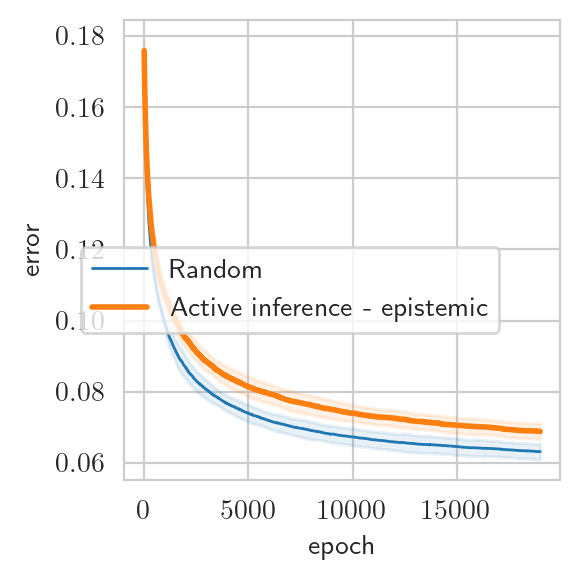

In [45]:
plot.error(run_random, run_af_epistemic)

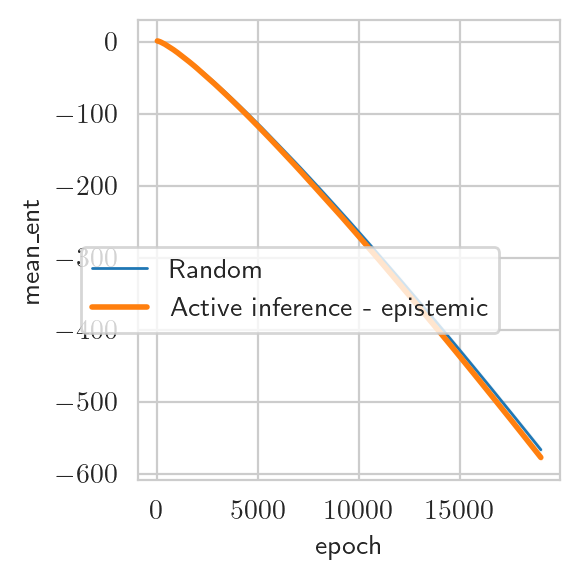

In [46]:
plot.error_like("mean_ent", run_random, run_af_epistemic)

# All together

In [171]:
def run_af(gammas=None, n_episode=200, n_sample=20, horizon=1, verbose=False):
    
    if gammas is None:
        gammas = np.arange(0, 1.2, 0.2)
        
    if verbose:
        pbar = None
    else:
        pbar = tqdm(total=n_episode*len(gammas)*n_sample*(n_timestep-1)) 
    
    runs = []
    for gamma_idx, gamma in enumerate(gammas):
        
        hist_err = np.zeros((n_sample, n_episode*(n_timestep-1)))
        hist_pos, hist_vel = np.zeros((n_sample, n_episode, n_timestep-1)), np.zeros((n_sample, n_episode, n_timestep-1))
        
        for sample in range(n_sample):
        
            # Initialize alpha
            _alpha_atvv = np.zeros((n_action, n_timestep, n_velocity, n_velocity)) + np.finfo(np.float64).eps
        
            # Log error
            # error = np.mean(np.absolute(transition_velocity_tavv - compute_q(alpha_tavv)))
            # print(f"[Sample {sample}] Initial error {error:.4f}")
        
            hist_a = []
            epoch = 0
        
            # with tqdm(total=n_episode) as pbar:
            for ep_idx in range(n_episode):
        
                np.random.seed(12334 + ep_idx + sample * 2 + gamma_idx * 3)
        
                pos_idx = np.absolute(position).argmin()  # Something close to 0
                v_idx = np.absolute(velocity).argmin()    # Something close to 0
        
                for t_idx in range(timestep.size-1):
        
                    h = min(horizon, n_timestep - t_idx -1)
                    action_plan = list(itertools.product(range(n_action), repeat=h))
        
                    # Initialize action plan values
                    pragmatic = np.zeros(len(action_plan))
                    epistemic = np.zeros(len(action_plan))
        
                    qt = compute_q(_alpha_atvv)
        
                    # Compute value of each action plan
                    for ap_index, ap in enumerate(action_plan):
        
                        qvs = np.zeros((h, n_velocity))
                        qps = np.zeros((h, n_position))
            
                        qv = np.zeros(n_velocity)
                        qv[v_idx] = 1.
                        qp = np.zeros(n_position)
                        qp[pos_idx] = 1.
            
                        for h_idx in range(h):
                            
                            previous_qv = qv.copy()
                            
                            a = ap[h_idx]
                            rollout_t_index = t_idx + h_idx
                            
                            _qt = qt[a, rollout_t_index]
                            
                            qv = qv @ _qt  # Using beliefs about velocity transitions
                            qp = qp @ (qv @ transition_position_pvp)
                            
                            # Equation B.34 (p 253) 
                            make_sense = _qt > 0
                            _qt += 1e-16
                            w = 1/(2*_qt) - 1/(2*np.sum(_qt, axis=-1, keepdims=True))  
                            w = w * make_sense.astype(float)
                            # E_Q[D_KL(Q(o) || Q(o|o'))]
                            v_model = (previous_qv@w)@qv
                            
                            # Eq B.29
                            # H(Q(o)) = - sum_i Q(o_i) log(Q(o_i)) - E_Q(s)[H[P(o |s)]]
                            # For a justification of the epistemic value for state, see p 137
                            # The second term is 0 because the entropy of the likelihood matrices is 0
                            # Because the likelihood is trivial, Q(o) = Q(s)
                            # v_state_p = - qp @ np.log(qp + 1e-16) # ---> Add or remove?
                            # v_state_v = - qv @ np.log(qv + 1e-16) # ---> Add or remove?
                            # v_state_c = - 0   # Context is known and perfectly predictable in this case
                            
                            # if h_idx == h-1:
                            epistemic[ap_index] += v_model # + v_state_v  # + v_state_p  # + v_model
                            
                            qvs[h_idx] = qv
                            qps[h_idx] = qp
                        
                        # Eq B.28
                        pragmatic[ap_index] = np.sum(qps @ log_prior)
                        
                    # Choose the best action plan
                    efe = gamma*epistemic + pragmatic
                    best_action_plan_index = np.random.choice(np.arange(len(action_plan))[np.isclose(efe, efe.max())])
                    a = action_plan[best_action_plan_index][0]
        
                    new_v_index = np.random.choice(n_velocity, p=transition_velocity_atvv[a, t_idx, v_idx, :])
        
                    # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
                    _alpha_atvv[a, t_idx, v_idx, new_v_index] += 1
        
                    # Update velocity and position
                    v_idx = new_v_index
                    pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])
        
                    # Log
                    error = np.mean(np.absolute(transition_velocity_atvv - compute_q(alpha_atvv)))
                    hist_err[sample, epoch] = error
                    hist_pos[sample, ep_idx, t_idx] = position[pos_idx]  
                    hist_vel[sample, ep_idx, t_idx] = velocity[v_idx]
                    hist_a.append(a)
                    epoch += 1
        
                    if pbar is not None:
                        pbar.update(1)

            if verbose:
                print(f"[Sample {sample}] Last position at the last episode {hist_pos[sample, -1, -1]:.2f}")
        
        runs.append({
            "gamma": gamma,
            "policy": "af", 
            "error": hist_err, 
            "position": hist_pos[:, :, :],  
            "velocity": hist_vel[:, :, :]})
    if pbar is not None:
        pbar.close()
    return runs

In [172]:
runs = run_af()

  0%|          | 0/456000 [00:00<?, ?it/s]

In [173]:
best_baseline = [r for r in baselines if r["policy"] == 'max-expected-velocity'][0]
best_baseline__position = best_baseline["position"][:, -1].mean()

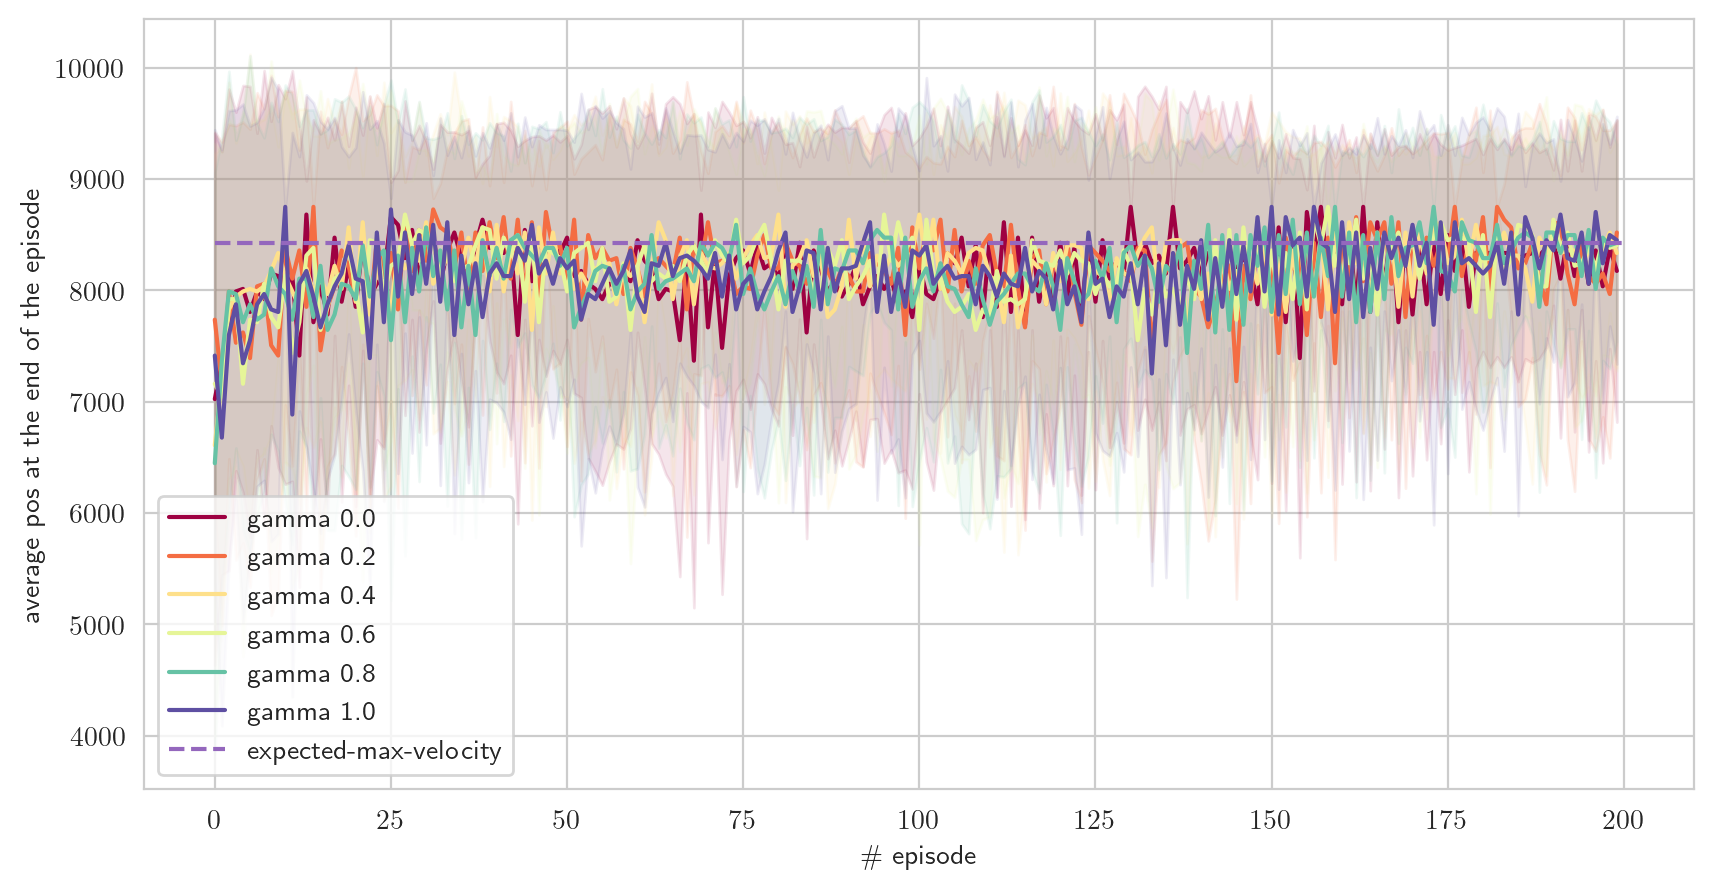

In [174]:
fig, ax = plt.subplots(figsize=(10, 5))

cmap = cm.get_cmap('Spectral')

for i, run in enumerate(runs):
    
    hist_pos = run["position"]
    gamma = run["gamma"]
    
    hist_mean = np.mean(hist_pos[:, :, -1], axis=0)
    hist_std = np.std(hist_pos[:, :, -1], axis=0)
    
    color = cmap(gamma)

    ax.fill_between(np.arange(len(hist_mean)), hist_mean - hist_std, hist_mean + hist_std, alpha=0.1, color=color)
    ax.plot(np.arange(len(hist_mean)), hist_mean, color=color, label=f"gamma {gamma:.1f}")
    
    
ax.hlines(best_baseline__position, 0, runs[0]["position"].shape[1], color="C4", linestyle="--", label="expected-max-velocity")
ax.legend()
ax.set_xlabel(r"\# episode")
ax.set_ylabel("average pos at the end of the episode");

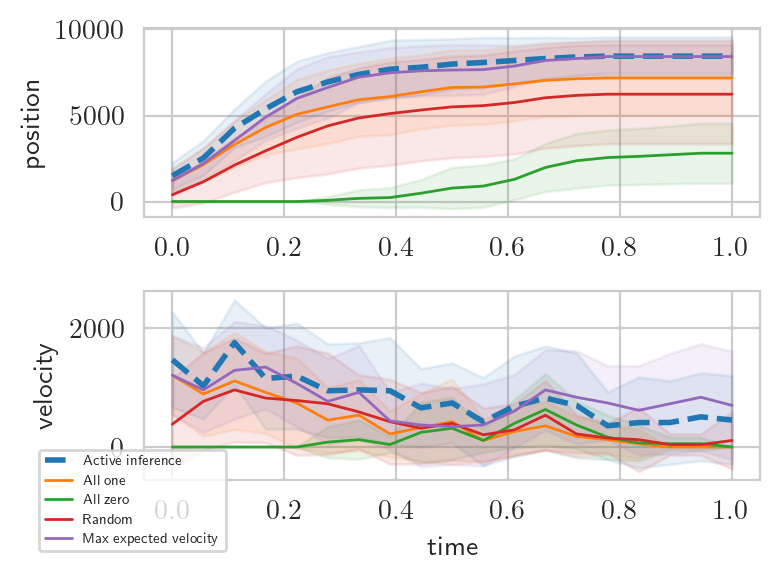

In [175]:
plot.runs(
    [_ for _ in runs if _["gamma"] == 1.0][0], # Run gamma = 1
    *baselines)